<h1>Statistics over the collected data<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment-configuration" data-toc-modified-id="Environment-configuration-1">Environment configuration</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2">Load data</a></span></li><li><span><a href="#Histogram-over-the-number-of-authors" data-toc-modified-id="Histogram-over-the-number-of-authors-3">Histogram over the number of authors</a></span></li><li><span><a href="#Distribution-of-the-pages-count" data-toc-modified-id="Distribution-of-the-pages-count-4">Distribution of the pages count</a></span></li><li><span><a href="#Distribution-of-the-number-of-figures-in-the-articles" data-toc-modified-id="Distribution-of-the-number-of-figures-in-the-articles-5">Distribution of the number of figures in the articles</a></span></li><li><span><a href="#Distribution-of-the-number-of-standalone-paragraphs" data-toc-modified-id="Distribution-of-the-number-of-standalone-paragraphs-6">Distribution of the number of standalone paragraphs</a></span></li><li><span><a href="#Distribution-of-the-number-of-sections" data-toc-modified-id="Distribution-of-the-number-of-sections-7">Distribution of the number of sections</a></span></li><li><span><a href="#Distribution-of-the-number-of-words-in-the-body" data-toc-modified-id="Distribution-of-the-number-of-words-in-the-body-8">Distribution of the number of words in the body</a></span></li></ul></div>

## Environment configuration

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load data

In [2]:
import findspark

from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import monotonically_increasing_id


# findspark.init('/usr/local/Cellar/apache-spark/3.0.1/libexec')
# 
# conf = SparkConf().setMaster("local").setAppName("My App")
# sc = SparkContext(conf=conf)
# spark = SparkSession(sc)

input_dir = "../datasets/2016_testing_df/"

def parse_paragraphs_list(list_of_paragraphs):
    list_of_paragraphs_to_ret = []
    if list_of_paragraphs != None:
        for paragraph in list_of_paragraphs:
            if paragraph != None:
                if type(paragraph) == str:
                    list_of_paragraphs_to_ret.append(paragraph)
                else:
                    if paragraph._VALUE != None:
                        list_of_paragraphs_to_ret.append(paragraph._VALUE)
    return list_of_paragraphs_to_ret


def get_paragraphs_list_from_body(input_dir):
    df = spark.read \
                .format('com.databricks.spark.xml') \
                .options(rowTag='record')\
                .options(rowTag='body')\
                .load(input_dir)
    return df.select("p")\
             .rdd\
             .map(lambda row: parse_paragraphs_list(row['p']))\
             .zipWithIndex()\
             .map(lambda record: (record[1], record[0]))


def parse_sections_list(list_of_sections):
    if list_of_sections != None:
        list_of_sections = [parse_paragraphs_list(section.p) for section in list_of_sections if section.p != None]
    else:
        list_of_sections = []
    return list_of_sections


def get_sections_list(input_dir):
    df = spark.read \
                .format('com.databricks.spark.xml') \
                .options(rowTag='record')\
                .options(rowTag='body')\
                .load(input_dir)
    return  df.select("sec")\
              .rdd\
              .map(lambda row: parse_sections_list(row['sec']), )\
              .zipWithIndex()\
              .map(lambda record: (record[1], record[0]))


def build_body(row_sec, row_p):
    concat_parsed_sections = ' '.join([' '.join(section) for section in parse_sections_list(row_sec)])
    concat_standalone_paragraphs = ' '.join(parse_paragraphs_list(row_p))
    return concat_standalone_paragraphs + " " + concat_parsed_sections


def get_bodys_list(input_dir):
    df = spark.read \
                .format('com.databricks.spark.xml') \
                .options(rowTag='record')\
                .options(rowTag='body')\
                .load(input_dir)
    return df.select("sec", "p")\
            .rdd\
            .map(lambda row: build_body(row['sec'], row["p"]))\
            .zipWithIndex()\
            .map(lambda record: (record[1], record[0]))


def get_abstract_list(input_dir):
    df = spark.read \
        .format('com.databricks.spark.xml') \
        .options(rowTag='record') \
        .options(rowTag='abstract') \
        .load(input_dir)
    return df.select("sec", "p") \
            .rdd \
            .map(lambda row: build_body(row['sec'], row["p"])) \
            .zipWithIndex() \
            .map(lambda record: (record[1], record[0]))


def get_article_categories(row):
    categories = []
    try: 
        for subj_group in row['subj-group']:
            if type(subj_group['subject']) == str:
                categories = [subj_group['subject']]
            elif type(subj_group['subject']) == list:
                for cat in subj_group['subject']:
                    categories.append(cat)
    except:
        return [row['subj-group']['subject']]
    return row['subj-group']


def get_categories_list(input_dir):
    df = spark.read \
              .format('com.databricks.spark.xml') \
              .options(rowTag='record') \
              .options(rowTag='metadata') \
              .options(rowTag='article') \
              .options(rowTag='front') \
              .options(rowTag='article-meta') \
              .load(input_dir)

    return df.select("article-categories") \
        .rdd \
        .map(lambda row: get_article_categories(row['article-categories'])) \
        .zipWithIndex() \
        .map(lambda record: (record[1], record[0]))


def get_titles_list(input_dir):
    df = spark.read \
        .format('com.databricks.spark.xml') \
        .options(rowTag='record') \
        .options(rowTag='metadata') \
        .options(rowTag='article') \
        .options(rowTag='front') \
        .options(rowTag='article-meta') \
        .options(rowTag='title-group') \
        .load(input_dir)

    return df.select("article-title") \
        .rdd \
        .map(lambda row: row['article-title']) \
        .zipWithIndex() \
        .map(lambda record: (record[1], record[0]))


def get_page_counts(row):
    try:
        return str(row['page-count']._count)
    except:
        return "Not specified"


def get_number_of_pages_list(input_dir):
    df = spark.read \
        .format('com.databricks.spark.xml') \
        .options(rowTag='record') \
        .options(rowTag='metadata') \
        .options(rowTag='article') \
        .load(input_dir)

    try:
        return df.select("counts") \
            .rdd \
            .map(lambda row: get_page_counts(row['counts'])) \
            .zipWithIndex() \
            .map(lambda record: (record[1], record[0]))
    except:
        return df.select("_xmlns") \
            .rdd \
            .map(lambda row: "Not specified") \
            .zipWithIndex() \
            .map(lambda record: (record[1], record[0]))


def get_authors(row):
    authors = []
    try:
        for contrib in row['contrib']:
            print(contrib)
            if contrib['_contrib-type'] == 'author':
                authors.append(contrib['name']['given-names'] + ' ' + contrib['name']['surname'])
        return authors
    except:
        return ['Not specified']


def get_authors_list(input_dir):
    df = spark.read \
        .format('com.databricks.spark.xml') \
        .options(rowTag='record') \
        .options(rowTag='metadata') \
        .options(rowTag='article') \
        .options(rowTag='front') \
        .options(rowTag='article-meta') \
        .load(input_dir)

    return df.select("contrib-group") \
        .rdd \
        .map(lambda row: get_authors(row['contrib-group'])) \
        .zipWithIndex() \
        .map(lambda record: (record[1], record[0]))


def get_affiliations(row):
    affiliations = dict()
    affiliations_for_authors = []
    try:
        for aff in row['aff']:
            affiliations[aff['_id']] = (aff['country'], aff['institution'])

        for contrib in row['contrib']:
            if contrib['_contrib-type'] == 'author':
                ids_aff = [aff['_rid'] for aff in contrib['xref']]
                affiliations_for_authors.append([])

                for id_aff in ids_aff:
                    affiliations_for_authors[-1].append(affiliations[id_aff])
        return affiliations_for_authors
    except:
        return ['Not specified']


def get_affiliations_list(input_dir):
    df = spark.read \
        .format('com.databricks.spark.xml') \
        .options(rowTag='record') \
        .options(rowTag='metadata') \
        .options(rowTag='article') \
        .options(rowTag='front') \
        .options(rowTag='article-meta') \
        .load(input_dir)

    return df.select("contrib-group") \
        .rdd \
        .map(lambda row: get_affiliations(row['contrib-group'])) \
        .zipWithIndex() \
        .map(lambda record: (record[1], record[0]))


def get_fig_no(row):
    try:
        if row['fig'] != None:
            if type(row['fig']) == list:
                return str(len(row['fig']))
            return "1"
        else:
            return 'Not specified'
    except:
        return 'Not specified'


def get_number_of_figures(input_dir):
    df = spark.read \
        .format('com.databricks.spark.xml') \
        .options(rowTag='record') \
        .load(input_dir)

    return df.select('fig') \
        .rdd \
        .map(lambda row: get_fig_no(row)) \
        .zipWithIndex() \
        .map(lambda record: (record[1], record[0]))


def get_simplified_rdd(input_dir):
    return get_abstract_list(input_dir) \
                .join(get_bodys_list(input_dir)) \
                .join(get_categories_list(input_dir)) \
                .join(get_titles_list(input_dir)) \
                .sortByKey()


def get_simplified_to_df(input_dir):
    return get_simplified_rdd(input_dir) \
                .map(lambda record: (record[1][0][0][0], record[1][0][0][1], record[1][0][1], record[1][1])) \
                .toDF(["abstract", "body", "categories", "title"]) \
                .withColumn("id", monotonically_increasing_id())


def get_final_rdd(input_dir):
    return get_abstract_list(input_dir) \
        .join(get_paragraphs_list_from_body(input_dir)) \
        .join(get_sections_list(input_dir)) \
        .join(get_bodys_list(input_dir)) \
        .join(get_categories_list(input_dir)) \
        .join(get_titles_list(input_dir)) \
        .join(get_number_of_pages_list(input_dir)) \
        .join(get_authors_list(input_dir)) \
        .join(get_affiliations_list(input_dir)) \
        .join(get_number_of_figures(input_dir)) \
        .sortByKey()


def get_final_to_df(input_dir):
    return get_final_rdd(input_dir) \
                .map(lambda record: (record[1][0][0][0][0][0][0][0][0][0],
                                     record[1][0][0][0][0][0][0][0][0][1],
                                     record[1][0][0][0][0][0][0][0][1],
                                     record[1][0][0][0][0][0][0][1],
                                     record[1][0][0][0][0][0][1],
                                     record[1][0][0][0][0][1],
                                     record[1][0][0][0][1],
                                     record[1][0][0][1],
                                     record[1][0][1],
                                     record[1][1]))\
                .toDF(["abstract", "paragraphs", "sections", "body", "categories", "title", "pages count",
                       "authors", "affiliations", "figures count"]) 


df = get_final_to_df(input_dir)

In [3]:
df.toPandas().head(10)

,abstract,paragraphs,sections,body,categories,title,pages count,authors,affiliations,figures count
0,Expression of the oncogenic transcription fact...,[We hypothesized that MYC-dependent metabolic ...,[[For U-]],We hypothesized that MYC-dependent metabolic d...,[Article],Inhibition of fatty acid oxidation as a therap...,Not specified,"[Roman Camarda, Zhou Zhou, Rebecca A. Kohnz, S...",[Not specified],Not specified
1,Membrane proteins are of outstanding importanc...,[A major challenge is maintaining membrane pro...,[[Membrane proteins are encoded by approx. 30%...,A major challenge is maintaining membrane prot...,[Article],A novel lipoprotein nanoparticle system for me...,Not specified,"[Jens Frauenfeld, Robin Löving, Jean-Paul Arma...",[Not specified],Not specified
2,Epidemiological and experimental data implicat...,[PGC-1α in skeletal muscle induces broad genet...,[[C2C12 cells were grown in 10 cm dishes until...,PGC-1α in skeletal muscle induces broad geneti...,[Article],A branched chain amino acid metabolite drives ...,Not specified,"[Cholsoon Jang, Sungwhan F Oh, Shogo Wada, Gle...",[Not specified],Not specified
3,Development of multicellular organisms is comm...,[Morphogenetic patterns observed in experiment...,[[The greatest manifestation of biological dev...,Morphogenetic patterns observed in experimenta...,[Article],Scaling of morphogenetic patterns in reaction-...,Not specified,"[Manan’Iarivo Rasolonjanahary, Bakhtier Vasiev]",[Not specified],Not specified
4,,[The heritability of muscle strength and power...,[[Environmental and genetic factors influence ...,The heritability of muscle strength and power ...,[Original Paper],Association analysis of,Not specified,[Not specified],[Not specified],Not specified
5,The performance of professional strength and p...,[Excessive body weight gain because of an incr...,[[Regular physical activity has significant be...,Excessive body weight gain because of an incre...,[Review Paper],Genetic variants influencing effectiveness of ...,Not specified,"[A Leońska-Duniec, II Ahmetov, P Zmijewski]",[Not specified],Not specified
6,Frequent and regular physical activity has sig...,[There is growing evidence linking T to motiva...,"[[In sport, the testosterone (T) contribution ...",There is growing evidence linking T to motivat...,[Original Paper],Temporal associations between individual chang...,Not specified,"[BT Crewther, J Carruthers, LP Kilduff, CE San...",[Not specified],Not specified
7,To advance our understanding of the hormonal c...,"[Nevertheless, the mechanism responsible for t...",[[Effective energy metabolism and transport of...,"Nevertheless, the mechanism responsible for th...",[Original Paper],The effect of the competitive season in profes...,Not specified,"[A Dzedzej, W Ignatiuk, J Jaworska, T Grzywacz...",[Not specified],Not specified
8,"Following acute physical activity, blood hepci...","[Fortunately, the session rating of perceived ...",[[The seven-a-side version of rugby union has ...,"Fortunately, the session rating of perceived e...",[Original Paper],Multifactorial monitoring of training load in ...,Not specified,"[T Bouaziz, E Makni, P Passelergue, Z Tabka, G...",[Not specified],Not specified
9,The effectiveness of selected physiological an...,[Research has examined set volume experimental...,[[Resistance training (RT) is widely recognise...,Research has examined set volume experimentall...,[Original Paper],A comparison of low volume 'high-intensity-tra...,Not specified,"[J Giessing, B Eichmann, J Steele, J Fisher]",[Not specified],Not specified


In [4]:
df.toPandas().describe()

,abstract,paragraphs,sections,body,categories,title,pages count,authors,affiliations,figures count
count,117,117,117,117,117,117,117,117,117,117
unique,102,106,96,117,22,117,3,97,15,4
top,,[],[],"Bovine spongiform encephalopathy (BSE), or Mad...",[Article],Greater eccentric exercise-induced muscle dama...,Not specified,[Not specified],[Not specified],Not specified
freq,16,12,15,1,27,1,115,21,103,112


## Histogram over the number of authors

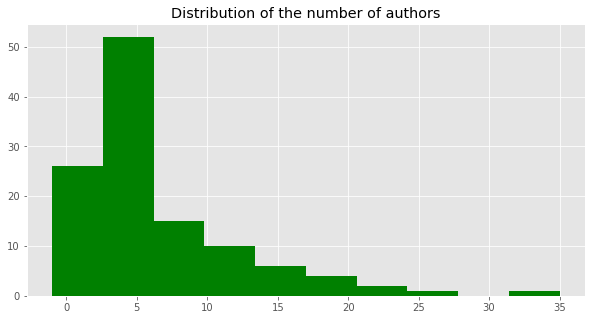

In [5]:
import matplotlib.pyplot as plt

def get_authors_number(x):
    if 'Not specified' not in x:
        return len(x)
    return -1

col = df.select('authors').rdd.map(lambda x: get_authors_number(x['authors']))\
                              .map(lambda x: (x, ))\
                              .toDF(['authors_number'])\
                              .toPandas()

fig = plt.figure(figsize=(10,5))
col['authors_number'].hist(color='green')
plt.title("Distribution of the number of authors")
plt.show()

## Distribution of the pages count

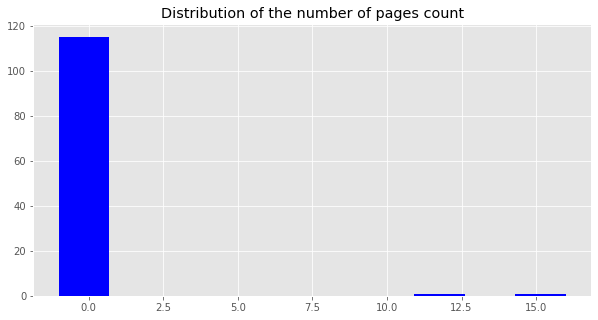

In [6]:
import matplotlib.pyplot as plt

def get_pages_number(x):
    if x.isnumeric():
        return int(x)
    return -1

col = df.select('pages count').rdd.map(lambda x: get_pages_number(x['pages count']))\
                              .map(lambda x: (x, ))\
                              .toDF(['pages_count'])\
                              .toPandas()

fig = plt.figure(figsize=(10,5))
col['pages_count'].hist(color='blue')
plt.title("Distribution of the number of pages count")
plt.show()

## Distribution of the number of figures in the articles

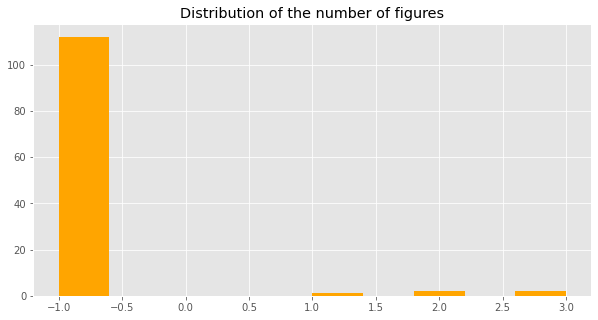

In [7]:
import matplotlib.pyplot as plt

def get_figures_number(x):
    if x.isnumeric():
        return int(x)
    return -1

data = df.select('figures count').rdd.map(lambda x: get_figures_number(x['figures count']))\
                              .map(lambda x: (x, ))\
                              .toDF(['figures_count'])\
                              .toPandas()

fig = plt.figure(figsize=(10,5))

# sns.distplot(data['figures_count'], hist = True, kde = False,
#              kde_kws = {'shade': True, 'linewidth': 3}, 
#              label = 'Distribution Waiting time')

data['figures_count'].hist(color='orange')
plt.title("Distribution of the number of figures")
plt.show()

## Distribution of the number of standalone paragraphs

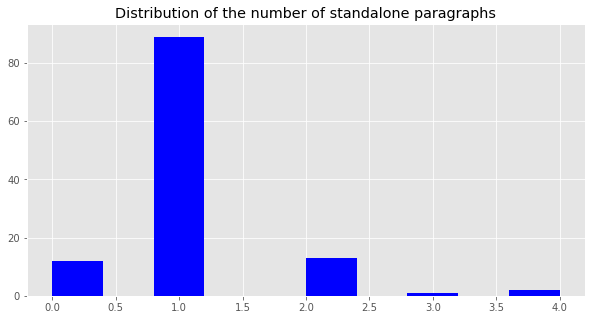

In [8]:
import matplotlib.pyplot as plt

def get_paragraphs_number(x):
    if 'Not specified' not in x:
        return len(x)
    return -1

col = df.select('paragraphs').rdd.map(lambda x: get_paragraphs_number(x['paragraphs']))\
                              .map(lambda x: (x, ))\
                              .toDF(['paragraphs_number'])\
                              .toPandas()

fig = plt.figure(figsize=(10,5))
col['paragraphs_number'].hist(color='blue')
plt.title("Distribution of the number of standalone paragraphs")
plt.show()

## Distribution of the number of sections

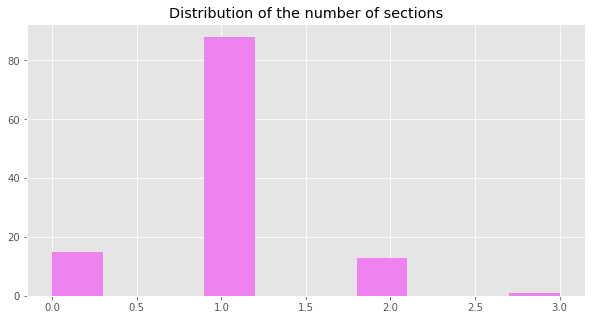

In [9]:
import matplotlib.pyplot as plt

def get_sections_number(x):
    if 'Not specified' not in x:
        return len(x)
    return -1

col = df.select('sections').rdd.map(lambda x: get_sections_number(x['sections']))\
                              .map(lambda x: (x, ))\
                              .toDF(['sections_number'])\
                              .toPandas()

fig = plt.figure(figsize=(10,5))
col['sections_number'].hist(color='violet')
plt.title("Distribution of the number of sections")
plt.show()

## Distribution of the number of words in the body

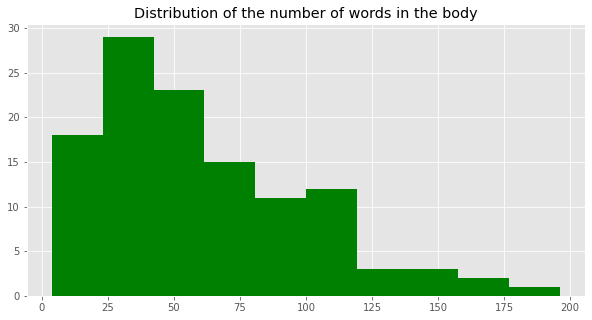

In [10]:
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize


def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

def split_text_into_words(text):
    text = remove_punctuation(text.lower())
    return word_tokenize(text)

def get_number_of_words_from_body(text):
    return len(split_text_into_words(text))

    
col = df.select('body').rdd.map(lambda x: get_number_of_words_from_body(x['body']))\
                              .map(lambda x: (x, ))\
                              .toDF(['body_words_count'])\
                              .toPandas()

fig = plt.figure(figsize=(10,5))
col['body_words_count'].hist(color='green')
plt.title("Distribution of the number of words in the body")
plt.show()